In [ ]:
!pip install -q mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
import cv2
import mediapipe as mp
import csv

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
RIGHT_KNEE = 26
RIGHT_ANKLE = 28
basepath = '/content/drive/MyDrive/University/Mechatronics/MP1/Assets/'

In [ ]:
def write_landmarks_to_csv(landmarks, frame_number, csv_data):
  csv_data.append([frame_number, landmarks[RIGHT_KNEE].x, landmarks[RIGHT_KNEE].y, landmarks[RIGHT_ANKLE].x, landmarks[RIGHT_ANKLE].y])

Initialize MediaPipe Pose and Drawing utilities

In [ ]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose()

Detect Pose Landmarks and Save them in a CSV

In [ ]:
for angle in ["Frontal", "Lateral"]:

    cap = cv2.VideoCapture(basepath + angle + ".mp4")

    frame_number = 0
    csv_data = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        result = pose.process(frame_rgb)

        if result.pose_landmarks:
            mp_drawing.draw_landmarks(frame, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            write_landmarks_to_csv(result.pose_landmarks.landmark, frame_number, csv_data)

        frame_number += 1


    with open(basepath + angle + ".csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)


Load the Saved Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dfx = pd.read_csv(basepath + "Frontal.csv", names=['id', 'ax', 'ay', 'bx', 'by'])
dfy = pd.read_csv(basepath + "Lateral.csv", names=['id', 'ax', 'ay', 'bx', 'by'])

Calculate $\theta_{x}$ and $\theta_{y}$

In [19]:
dfx['dy'] = dfx['by'] - dfx['ay']
dfx['dx'] = dfx['bx'] - dfx['ax']
dfx['theta_x'] = np.arctan2(dfx['dx'], dfx['dy'])
dfx['theta_deg_x'] = np.degrees(dfx['theta_x'])

dfy['dy'] = dfy['by'] - dfy['ay']
dfy['dx'] = dfy['bx'] - dfy['ax']
dfy['theta_y'] = np.arctan2(dfy['dx'], dfy['dy'])
dfy['theta_deg_y'] = np.degrees(dfy['theta_y'])

raw_df = pd.concat([dfx['id'], dfx['theta_x'], dfy['theta_y']], axis=1)
raw_df.to_csv(basepath + 'Raw_Angles.csv', index=False)

Function to Extract Natural Parameters ($\vec{e}$ and $\phi$)

In [11]:
def rotation_matrix_to_natural_parameters(R):

    epsilon = 1e-12

    trace_R = np.trace(R)

    phi = np.arccos((trace_R - 1) / 2.0)

    if np.abs(phi) < epsilon:
        e = np.zeros(3)
    else:
        e = 1 / (2 * np.sin(phi)) * np.array([
            R[2, 1] - R[1, 2],
            R[0, 2] - R[2, 0],
            R[1, 0] - R[0, 1]
        ])

    return e, phi

Plot the Angles

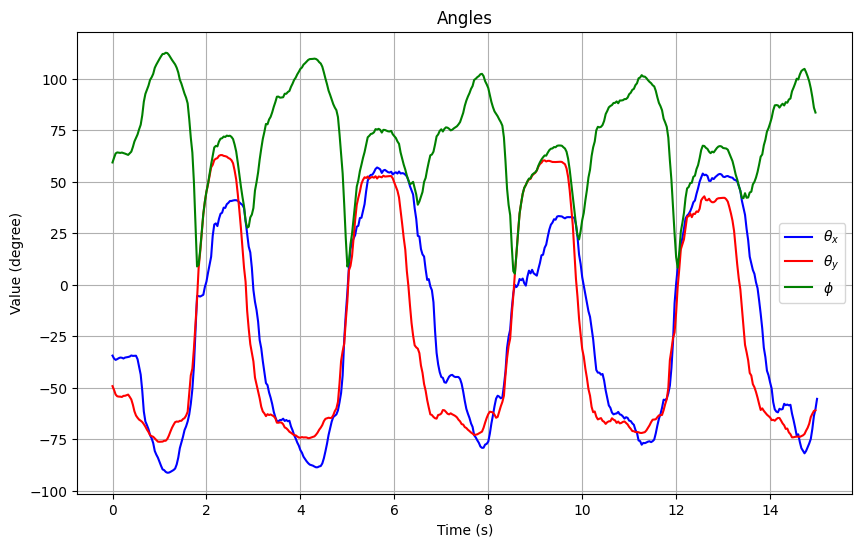

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def compute_rotation_matrix(thetax, thetay):
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(thetax), -np.sin(thetax)],
                   [0, np.sin(thetax), np.cos(thetax)]])

    Ry = np.array([[np.cos(thetay), 0, np.sin(thetay)],
                   [0, 1, 0],
                   [-np.sin(thetay), 0, np.cos(thetay)]])

    return Rx, Ry

timeframes = dfy['id'].values
num_frames = dfy['theta_y'].values.shape[0]
thetax = dfx['theta_x'].values
thetay = dfy['theta_y'].values


phis = []


for i in range(num_frames):

    Rx, Ry = compute_rotation_matrix(thetax[i], thetay[i])
    R_global = np.dot(Rx, Ry)

    e, phi = rotation_matrix_to_natural_parameters(R_global)
    phis.append(phi)


phis = np.array(phis)

plt.figure(figsize=(10, 6))

plt.plot(dfx['id']/30, dfx['theta_deg_x'], color='blue', label=r'$\theta_{x}$')
plt.plot(dfy['id']/30, dfy['theta_deg_y'],color='red', label=r'$\theta_{y}$')
plt.plot(dfy['id']/30, phis/np.pi*180, color='green', label=r'$\phi$')
plt.xlabel('Time (s)')
plt.ylabel('Value (degree)')
plt.title('Angles')
plt.legend()
plt.grid(True)
plt.show()


After offline Smoothing

In [24]:
df = pd.read_csv(basepath + "Smooth_Angles.csv",header=0)

timeframes = df['timeframes'].values
num_frames = df['timeframes'].values.shape[0]
thetax = df['thetax_smooth'].values
thetay = df['thetay_smooth'].values

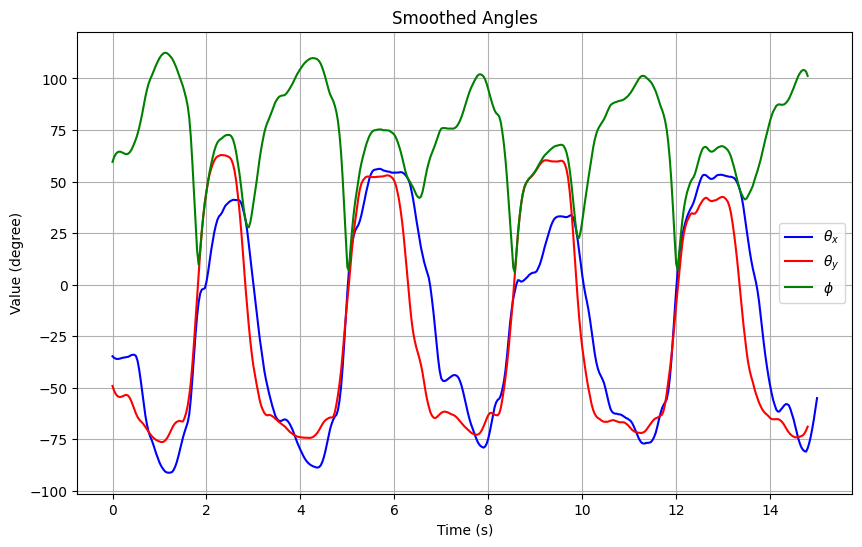

In [28]:


phis = []

for i in range(num_frames):

    Rx, Ry = compute_rotation_matrix(thetax[i], thetay[i])
    R_global = np.dot(Rx, Ry)

    e, phi = rotation_matrix_to_natural_parameters(R_global)
    phis.append(phi)



phis = np.array(phis)

plt.figure(figsize=(10, 6))

plt.plot(timeframes/30, np.degrees(thetax), color='blue', label=r'$\theta_{x}$')
plt.plot(timeframes/30, np.degrees(thetay),color='red', label=r'$\theta_{y}$')
plt.plot(timeframes/30, np.degrees(phis), color='green', label=r'$\phi$')
plt.xlabel('Time (s)')
plt.ylabel('Value (degree)')
plt.title('Smoothed Angles')
plt.legend()
plt.grid(True)
plt.show()